In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15.0, 7.0)
sns.set(style="ticks")

In [15]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from lending-club.loan import Loan
from lending-club.investor import Investor
from backtest import Backtest

SyntaxError: invalid syntax (<ipython-input-19-9b43ee764e58>, line 1)

In [8]:
from lc_helpers import (df_ols, fix_issue_date, create_relevant_subset, 
create_factors, remove_nans, get_db_folder, make_df_numeric)

In [9]:
db = get_db_folder()
training = pd.read_csv(db['training']).pipe(make_df_numeric)
testing = pd.read_csv(db['testing']).pipe(make_df_numeric)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
def buy_solver_one(month, investor, month_db, number):
    return month_db.iloc[0:number - 1, :]

In [11]:
input_db = pd.concat([training, testing])

In [12]:
dates = sorted(input_db['issue_d'].unique())
dates[0], dates[-1]

(Period('2007-06', 'M'), Period('2012-12', 'M'))

In [11]:
# buy_function_one(pd.Period('20150101', freq='M'), doug)

In [13]:
%autoreload Backtest
bt = Backtest(dates[0], dates[-1], buy_solver_one, input_db)

In [14]:
result = bt.run()

2007-06 2012-12
2007-07 2012-12
2007-08 2012-12
2007-09 2012-12
2007-10 2012-12
2007-11 2012-12
2007-12 2012-12
2008-01 2012-12
-0.0152992397117 0
-0.0134888251726 0
2008-02 2012-12
-0.0152943010866 0
2008-03 2012-12
-0.0189426291487 0
0.0370462110007 1
2008-04 2012-12
-0.0259681517279 0
-9.14149128982e-06 0
2008-05 2012-12
0.0619049803682 1
0.0476021143444 1
-0.0244102008421 0
2008-06 2012-12
2008-07 2012-12
2008-08 2012-12
0.00211008516851 0
-0.0138850332845 0
2008-09 2012-12
2008-10 2012-12
2008-11 2012-12
2008-12 2012-12
2009-01 2012-12
2009-02 2012-12
2009-03 2012-12
-0.0327486712994 0
2009-04 2012-12
-0.021166028769 0
-0.0149175106518 0
0.0169353189756 0
2009-05 2012-12
2009-06 2012-12
-0.000201293355683 0
2009-07 2012-12
-0.0294466449167 0
0.0909685640014 1
0.0509304119069 1
-0.0111266928819 0
2009-08 2012-12
-0.0212315473973 0
2009-09 2012-12
2009-10 2012-12
0.0732280831241 1
2009-11 2012-12
2009-12 2012-12
-0.00430702065233 0
2010-01 2012-12
2010-02 2012-12
-5.24736141202e-05 

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:1225: FutureWarning: slice indexers when using iloc should be integers and not floating point
  return self._getitem_tuple(key)


In [16]:
bt.stats_dict['sharpe']

1.7182113448365302

In [17]:
bt.stats.tail(10)

,available loans,cash held,cumulative defaults,cumulative loans held,imbalance,imbalance %,loans added,loans held,net worth,defaults,monthly return,annualized return,growth of $1
2012-03,2357,41.579958,16,207,-2.562141,-0.001955,3,90,1310.426466,0,0.008285,NaN,1.310426
2012-04,2680,29.272293,16,211,-3.336685,-0.002525,4,92,1321.283108,0,-0.003378,NaN,1.321283
2012-05,2741,47.425099,17,214,-2.589617,-0.001967,3,91,1316.819428,1,-0.013601,NaN,1.316819
2012-06,3048,38.175714,19,218,-1.203868,-0.000927,4,91,1298.910014,2,0.008584,NaN,1.298910
2012-07,3781,29.337955,19,222,-4.636691,-0.003539,4,90,1310.059232,0,0.006196,NaN,1.310059
2012-08,4461,42.293983,20,225,-5.938034,-0.004505,3,90,1318.176226,1,-0.008978,NaN,1.318176
2012-09,5080,25.974089,21,229,-7.685227,-0.005883,4,90,1306.341105,1,-0.000712,NaN,1.306341
2012-10,5202,43.036369,22,232,-6.359017,-0.004871,3,92,1305.411108,1,-0.019970,NaN,1.305411
2012-11,5175,36.828621,24,236,-6.205197,-0.004850,4,91,1279.341760,2,0.009334,NaN,1.279342
2012-12,4804,30.881405,24,240,-10.582433,-0.008195,4,90,1291.282972,0,NaN,NaN,1.291283


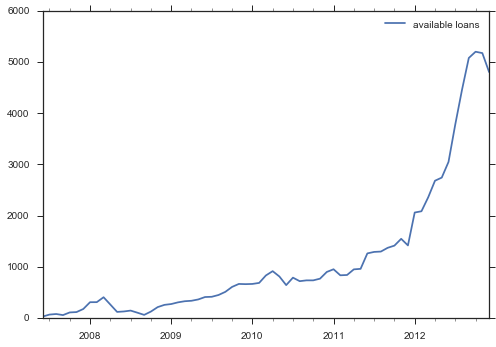

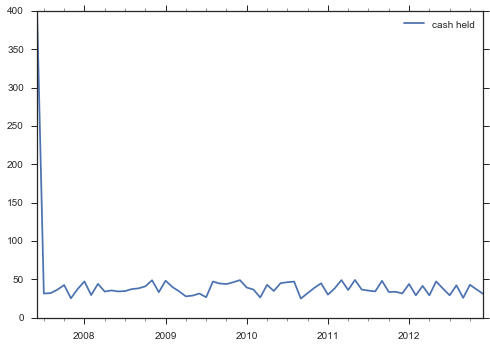

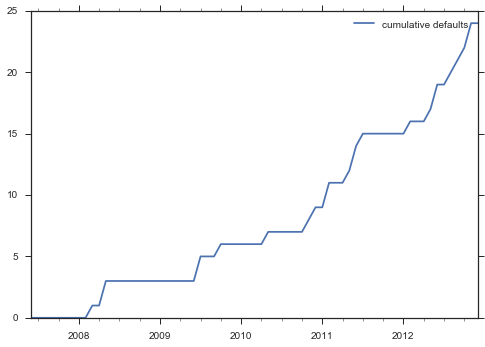

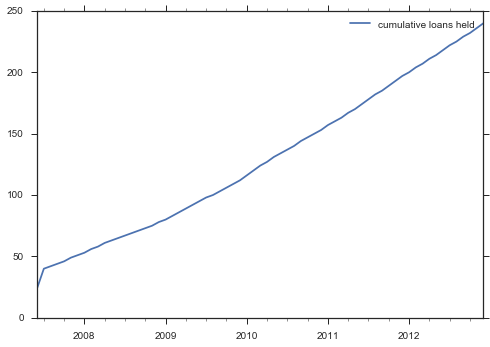

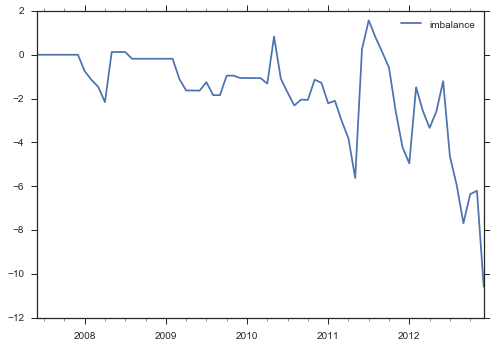

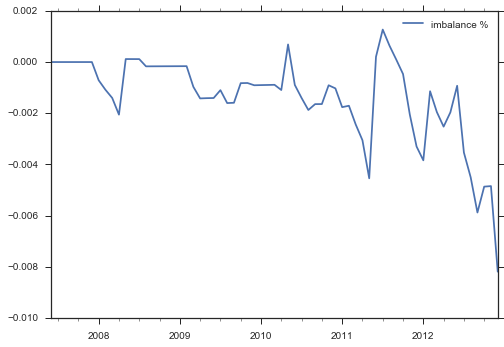

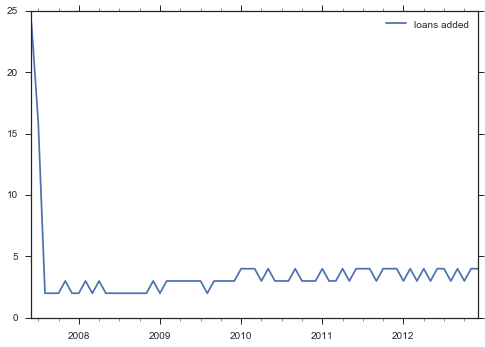

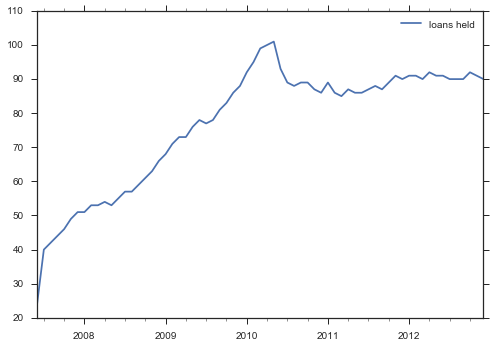

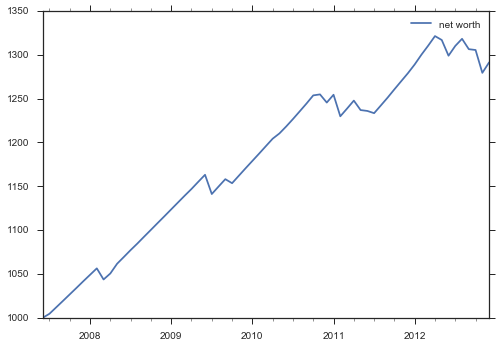

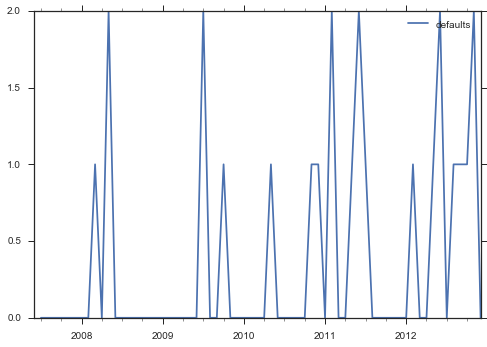

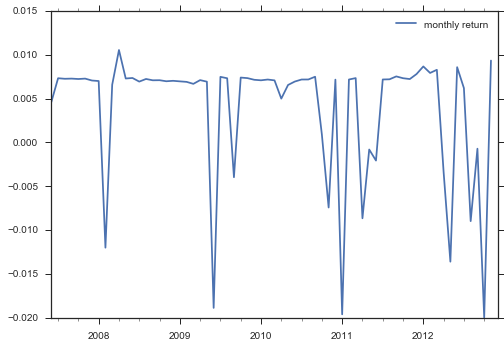

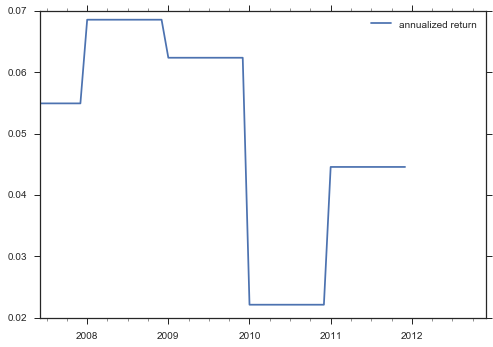

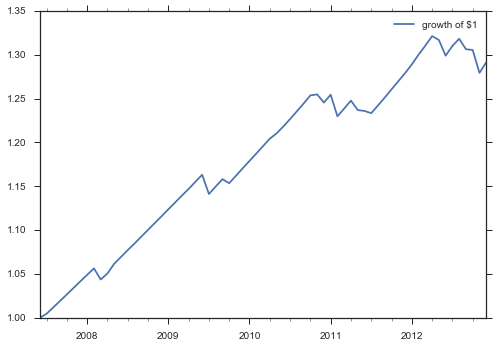

In [18]:
for column in bt.stats.columns:
    bt.stats[column].plot(label=column)
    plt.legend()
    plt.show()

In [78]:
bt.stats_dict['sharpe']

1.7182113448365302

In [133]:
(pd.DataFrame(bt.statistics)['net worth'].resample('M').diff().shift(-1) / pd.DataFrame(bt.statistics)['net worth'].resample('M')).plot(label='annualized return')
plt.legend()

AttributeError: backtest instance has no attribute 'statistics'

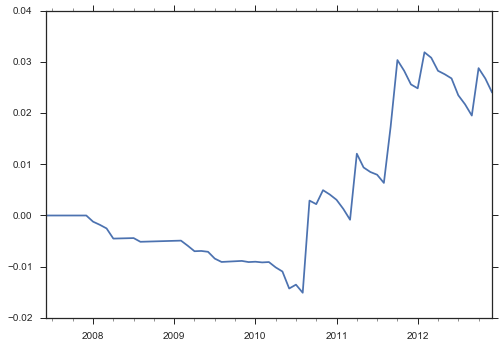

In [103]:
pd.DataFrame(bt.statistics)['imbalance %'].plot()

In [178]:
doug.buy_loan(loan1)

In [179]:
doug.balance

975.0

In [180]:
while doug.loans:
    doug.get_payments()
    print doug.balance

976.330209375
977.66041875
978.990628125
980.3208375
981.651046875
982.98125625
984.311465625
985.641675
986.971884375
988.30209375
989.632303125
990.9625125
992.292721875
993.62293125
994.953140625
996.28335
997.613559375
998.94376875
1000.27397812
1001.6041875
1002.91938499


In [181]:
doug.cum_imbalance

0.086530819249264826

In [22]:
while loan1.amount > 0:
    print loan1.remaining_term, loan1.amount, loan1.make_payment()

36 12000 {'interest': 135.30000000000001, 'principal': 272.10000000000002}
35 11727.9 {'interest': 132.22999999999999, 'principal': 275.17000000000002}
34 11452.7320725 {'interest': 129.13, 'principal': 278.26999999999998}
33 11174.4616266 {'interest': 125.98999999999999, 'principal': 281.41000000000003}
32 10893.0536815 {'interest': 122.81999999999999, 'principal': 284.57999999999998}
31 10608.4728617 {'interest': 119.61, 'principal': 287.79000000000002}
30 10320.6833932 {'interest': 116.37, 'principal': 291.02999999999997}
29 10029.6490985 {'interest': 113.08, 'principal': 294.31999999999999}
28 9735.33339208 {'interest': 109.77, 'principal': 297.63}
27 9437.69927607 {'interest': 106.41, 'principal': 300.99000000000001}
26 9136.70933541 {'interest': 103.02, 'principal': 304.38}
25 8832.32573317 {'interest': 99.579999999999998, 'principal': 307.81999999999999}
24 8524.51020581 {'interest': 96.109999999999999, 'principal': 311.29000000000002}
23 8213.22405838 {'interest': 92.5999999999

In [36]:
m_i

0.03153611111111121

In [37]:
P = 12000
r = m_i
n = 36

In [38]:
P * (r* (1.0+r)**n) / ((1.0+r)**n - 1)

562.3159701868747

In [20]:
(12000) * (1.0 + (0.1353 / 36))**36 / 36

381.52995792572216

In [7]:
loan(4, 'B', 0.10, ' 36 months', 3000, pd.Period('2016'))

In [8]:
loan

100

In [3]:
db = get_db_folder()
training = pd.read_csv(db['training']).pipe(make_df_numeric)
testing = pd.read_csv(db['testing']).pipe(make_df_numeric)

In [4]:
training = pd.read_csv(db['training']).pipe(make_df_numeric)
testing = pd.read_csv(db['testing']).pipe(make_df_numeric)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
